# Preprotion

In [1]:
import shutil
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
import transformers
from sklearn.metrics import precision_score, recall_score, f1_score,\
 accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# data path
data_paths = {}
data_paths["H"] = '/content/drive/MyDrive/Data/AFRD/All_Dataset/Hotel.xlsx' # hotel
data_paths["R"] = '/content/drive/MyDrive/Data/AFRD/All_Dataset/Resturent.xlsx' # resturent
data_paths["P"] = '/content/drive/MyDrive/Data/AFRD/All_Dataset/Prodect.xlsx' # prodect

target_list = ['Fake', 'Truthful']

In [5]:
b_tokenizer = transformers.AutoTokenizer.from_pretrained("/content/drive/MyDrive/Models/tokenizers-bert-base-arabertv2")

In [6]:
MAX_LEN = 265
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2.5e-05

# Build the Model

In [7]:
class AFRD(Dataset):
    def __init__(self, dataset, tokenizer, max_len):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text = self.dataset["Text"]
        self.targets = self.dataset[target_list].values
        self.n_samples = self.dataset.shape[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        review = str(self.text[index])
        review = " ".join(review.split())

        inputs = self.tokenizer.encode_plus(review,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True,
                                            return_attention_mask=True,
                                            return_tensors="pt"
                                            )

        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "token_type_ids": inputs["token_type_ids"].flatten(),
            "targets": torch.FloatTensor(np.array(self.targets[index])).flatten()
        }

In [8]:
class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = transformers.AutoModel.from_pretrained("/content/drive/MyDrive/Models/model-bert-base-arabertv2", return_dict=True)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(input_ids, attention_mask, token_type_ids)
        output_dropout = self.dropout(output["pooler_output"])
        output = self.linear(output_dropout)
        return output


In [9]:
model = BERTClass()
model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/Models/model-bert-base-arabertv2 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

# saving & loadding Function


In [10]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']

    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

# Loss Function & optimizer

In [11]:
def loss_fn(output, target):
    return nn.BCEWithLogitsLoss()(output, target)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Training Function

In [12]:
def train_model(
        n_epochs,
        training_loader,
        validation_loader,
        model,
        optimizer,
        checkpoint_path,
        best_model_path
):
    train_loss_list = []
    valid_loss_list = []

    n_total_steps_train = len(training_loader)
    n_total_steps_valid = len(validation_loader)

    valid_loss_min = np.Inf

    for epoch in range(n_epochs):

        sum_train_loss = 0
        sum_valid_loss = 0
        train_loss = 0
        valid_loss = 0
        model.train()
        # train

        for index, batch in enumerate(training_loader):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            targets = batch['targets'].to(device, dtype=torch.float)


            # forward pass
            output = model(input_ids, attention_mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(output, targets)
            optimizer.zero_grad()

            # backward pass
            loss.backward()
            optimizer.step()

            train_loss = train_loss + (1/(index+1)*(loss.item()-train_loss))
            sum_train_loss += train_loss
            print(f"epoch {epoch + 1}/{n_epochs}, step {index + 1}/{n_total_steps_train}, train_loss={train_loss:.4f}")
            # optimizer.zero_grad()

        # valid
        model.eval()
        with torch.no_grad():
            for index, batch in enumerate(validation_loader):
                input_ids = batch["input_ids"].to(device, dtype=torch.long)
                attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
                targets = batch['targets'].to(device, dtype=torch.float)
                output = model(input_ids, attention_mask, token_type_ids)

                loss = loss_fn(output, targets)
                valid_loss = valid_loss + (1 / (index + 1) * (loss.item() - valid_loss))
                sum_valid_loss += valid_loss
                print(f"epoch {epoch + 1}/{n_epochs}, step {index + 1}/{n_total_steps_valid}, valid_loss={loss.item():.4f}")

        checkpoint = {
            "epoch": epoch + 1,
            "valid_loss_min": valid_loss,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }

        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        train_loss_list.append(sum_train_loss/n_total_steps_train)
        valid_loss_list.append(sum_valid_loss/n_total_steps_valid)
    # Train & Valid loss Curve
    # Generate a sequence of integers to represent the epoch numbers
    epochs_r = list(range(1, n_epochs+1))
    print(train_loss_list)
    print(epochs_r)

    # Plot and label the training and validation loss values
    plt.plot(epochs_r, train_loss_list, label='Training Loss')
    plt.plot(epochs_r, valid_loss_list, label='Validation Loss')

    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Set the tick locations
    plt.xticks(range(1, n_epochs+1, 1))

    # Display the plot
    plt.legend(loc='best')
    plt.show()


# Test Function

In [13]:
def test_model(model, test_data):
  metrics_0 = {}
  metrics_1 = {}
  test_len = test_data.shape[0]
  text_test = test_data["Text"]
  targets_test = test_data[target_list].to_numpy().reshape(-1,2)
  del test_data
  targets_pred = []

  model.eval()
  with torch.no_grad():
    for review in text_test:
        review = str(review)
        emb = b_tokenizer.encode_plus(review,
                                      None,
                                      add_special_tokens=True,
                                      max_length=MAX_LEN,
                                      padding="max_length",
                                      truncation=True,
                                      return_attention_mask=True,
                                      return_tensors="pt"
                                      )

        input_ids = emb["input_ids"].to(device, dtype=torch.long)
        attention_mask = emb['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = emb['token_type_ids'].to(device, dtype=torch.long)

        res = model(input_ids, attention_mask, token_type_ids)
        final_res = torch.sigmoid(res).cpu().detach().numpy()

        targets_pred.append(final_res)

  targets_pred = np.array(targets_pred).reshape(-1,2)
  targets_pred = np.apply_along_axis(max_class, 1, targets_pred)

  metrics_0["accuracy_score"] = accuracy_score(targets_test[:, 0], targets_pred[:, 0])
  metrics_0["precision_score"] =  precision_score(targets_test[:, 0], targets_pred[:, 0])
  metrics_0["recall_score"] = recall_score(targets_test[:, 0], targets_pred[:, 0])
  metrics_0["f1_score"] =  f1_score(targets_test[:, 0], targets_pred[:, 0])

  metrics_1["accuracy_score"] = accuracy_score(targets_test[:, 1], targets_pred[:, 1])
  metrics_1["precision_score"] =  precision_score(targets_test[:, 1], targets_pred[:, 1])
  metrics_1["recall_score"] = recall_score(targets_test[:, 1], targets_pred[:, 1])
  metrics_1["f1_score"] =  f1_score(targets_test[:, 1], targets_pred[:, 1])

  confusion_matrix_res = confusion_matrix(targets_test[:, 0], targets_pred[:, 0])

  cm_display = ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix_res,
      display_labels=[0, 1])

  print(f"metrics_0: {metrics_0}\n metrics_1: {metrics_1}")
  print(classification_report(targets_test[:, 0], targets_pred[:, 0], target_names=['Truthful', 'Fake']))
  cm_display.plot()
  plt.show()

In [14]:
def max_class(item):
  item = np.where(item == max(item), 1, 0)
  return item

# Multi data training/Testing

In [15]:
def pipeline(data_paths, model, optimizer, train_fn, test_fn):
  curr_stage = ''
  total_test = pd.DataFrame(columns=['Text', 'Fake', 'Truthful'])
  exe_seq = ["H", "R", "P"]
  for i in exe_seq:
    # import the data set
    data = pd.read_excel(data_paths[i])
    data.drop(labels=['Age', 'Gender','Platform/Name', 'Product', 'Rating', 'Polarity'], axis=1, inplace=True)
    target_list = ['Fake', 'Truthful']

    # encoding
    enc_y_data = pd.get_dummies(data['Class'], dtype=float)
    data[target_list] = enc_y_data[target_list]
    data.drop(labels=['Class'], axis=1, inplace=True)

    # splitting the data into train, valid, test
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=32, shuffle=True)
    train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=32, shuffle=True,)

    train_data.reset_index(drop=True, inplace=True)
    valid_data.reset_index(drop=True, inplace=True)
    test_data.reset_index(drop=True, inplace=True)

    train_data = AFRD(train_data, b_tokenizer, MAX_LEN)
    valid_data = AFRD(valid_data, b_tokenizer, MAX_LEN)

    train_data_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=0
    )

    val_data_loader = DataLoader(
    valid_data,
    shuffle=False,
    batch_size=VALID_BATCH_SIZE,
    num_workers=0
    )
    # optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    del train_data, valid_data

    curr_stage = curr_stage + f"{i}"
    print(f'############################-{curr_stage}model-################################')
    # Training
    train_fn(EPOCHS, train_data_loader, val_data_loader, model, optimizer, f"./{curr_stage}_curr_ck.pt", f"./{curr_stage}_best.pt")
    # del optimizer
    # Testing
    test_fn(model, test_data)

    del train_data_loader, val_data_loader
    total_test = pd.concat([total_test, test_data], ignore_index=True)
    del test_data

  print('###############################-Final Test-#######################################')

  test_fn(model, total_test)


############################-Hmodel-################################
epoch 1/4, step 1/12, train_loss=0.6875
epoch 1/4, step 2/12, train_loss=0.7032
epoch 1/4, step 3/12, train_loss=0.7053
epoch 1/4, step 4/12, train_loss=0.7005
epoch 1/4, step 5/12, train_loss=0.6925
epoch 1/4, step 6/12, train_loss=0.6905
epoch 1/4, step 7/12, train_loss=0.6864
epoch 1/4, step 8/12, train_loss=0.6831
epoch 1/4, step 9/12, train_loss=0.6787
epoch 1/4, step 10/12, train_loss=0.6687
epoch 1/4, step 11/12, train_loss=0.6661
epoch 1/4, step 12/12, train_loss=0.6675
epoch 1/4, step 1/3, valid_loss=0.6647
epoch 1/4, step 2/3, valid_loss=0.6239
epoch 1/4, step 3/3, valid_loss=0.6787
epoch 2/4, step 1/12, train_loss=0.6425
epoch 2/4, step 2/12, train_loss=0.6087
epoch 2/4, step 3/12, train_loss=0.6153
epoch 2/4, step 4/12, train_loss=0.6164
epoch 2/4, step 5/12, train_loss=0.6008
epoch 2/4, step 6/12, train_loss=0.5927
epoch 2/4, step 7/12, train_loss=0.5941
epoch 2/4, step 8/12, train_loss=0.5866
epoch 2/4, 

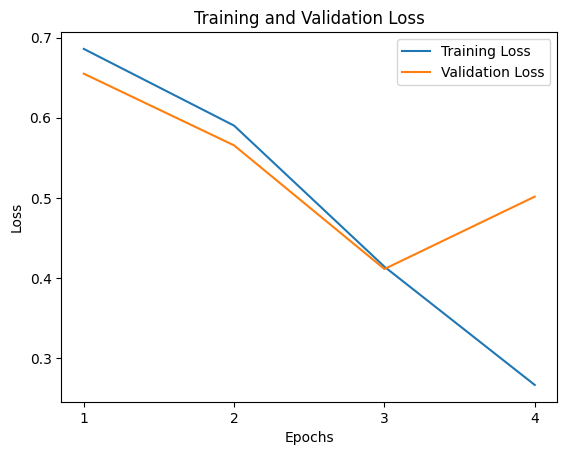

metrics_0: {'accuracy_score': 0.782051282051282, 'precision_score': 0.6808510638297872, 'recall_score': 0.9411764705882353, 'f1_score': 0.7901234567901235}
 metrics_1: {'accuracy_score': 0.782051282051282, 'precision_score': 0.9354838709677419, 'recall_score': 0.6590909090909091, 'f1_score': 0.7733333333333332}
              precision    recall  f1-score   support

    Truthful       0.94      0.66      0.77        44
        Fake       0.68      0.94      0.79        34

    accuracy                           0.78        78
   macro avg       0.81      0.80      0.78        78
weighted avg       0.82      0.78      0.78        78



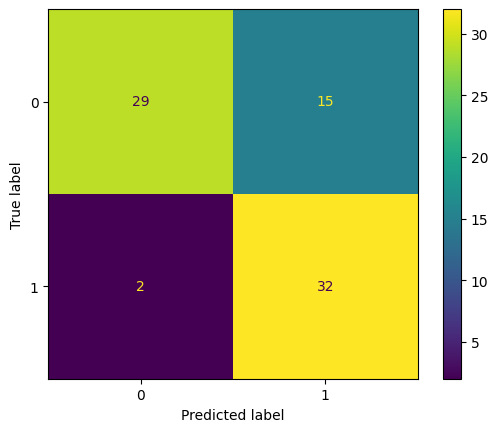

############################-HRmodel-################################
epoch 1/4, step 1/27, train_loss=0.4716
epoch 1/4, step 2/27, train_loss=0.4669
epoch 1/4, step 3/27, train_loss=0.4812
epoch 1/4, step 4/27, train_loss=0.4960
epoch 1/4, step 5/27, train_loss=0.4716
epoch 1/4, step 6/27, train_loss=0.5181
epoch 1/4, step 7/27, train_loss=0.5150
epoch 1/4, step 8/27, train_loss=0.5022
epoch 1/4, step 9/27, train_loss=0.4819
epoch 1/4, step 10/27, train_loss=0.4606
epoch 1/4, step 11/27, train_loss=0.4717
epoch 1/4, step 12/27, train_loss=0.4879
epoch 1/4, step 13/27, train_loss=0.5066
epoch 1/4, step 14/27, train_loss=0.5001
epoch 1/4, step 15/27, train_loss=0.5088
epoch 1/4, step 16/27, train_loss=0.5014
epoch 1/4, step 17/27, train_loss=0.5095
epoch 1/4, step 18/27, train_loss=0.5104
epoch 1/4, step 19/27, train_loss=0.5031
epoch 1/4, step 20/27, train_loss=0.4964
epoch 1/4, step 21/27, train_loss=0.4885
epoch 1/4, step 22/27, train_loss=0.5013
epoch 1/4, step 23/27, train_loss=0.4

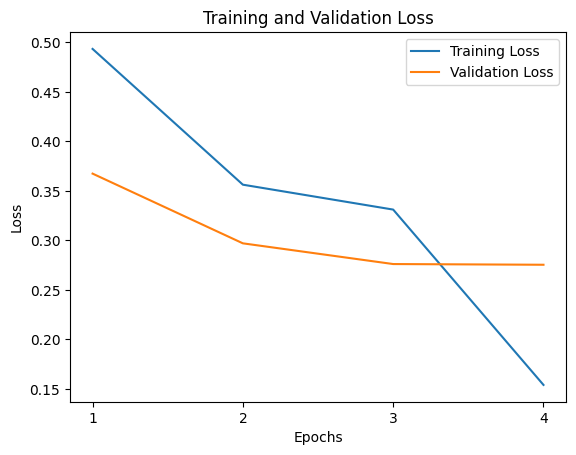

metrics_0: {'accuracy_score': 0.8100558659217877, 'precision_score': 0.8780487804878049, 'recall_score': 0.75, 'f1_score': 0.8089887640449439}
 metrics_1: {'accuracy_score': 0.8100558659217877, 'precision_score': 0.7525773195876289, 'recall_score': 0.8795180722891566, 'f1_score': 0.8111111111111111}
              precision    recall  f1-score   support

    Truthful       0.75      0.88      0.81        83
        Fake       0.88      0.75      0.81        96

    accuracy                           0.81       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.81      0.81       179



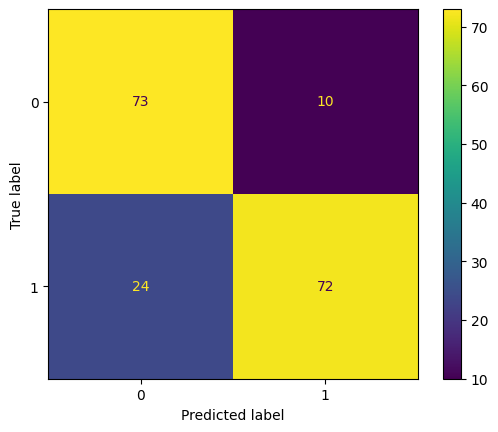

############################-HRPmodel-################################
epoch 1/4, step 1/27, train_loss=0.4812
epoch 1/4, step 2/27, train_loss=0.5592
epoch 1/4, step 3/27, train_loss=0.6815
epoch 1/4, step 4/27, train_loss=0.6838
epoch 1/4, step 5/27, train_loss=0.6620
epoch 1/4, step 6/27, train_loss=0.6945
epoch 1/4, step 7/27, train_loss=0.6639
epoch 1/4, step 8/27, train_loss=0.6402
epoch 1/4, step 9/27, train_loss=0.6630
epoch 1/4, step 10/27, train_loss=0.6666
epoch 1/4, step 11/27, train_loss=0.6553
epoch 1/4, step 12/27, train_loss=0.6632
epoch 1/4, step 13/27, train_loss=0.6562
epoch 1/4, step 14/27, train_loss=0.6324
epoch 1/4, step 15/27, train_loss=0.6306
epoch 1/4, step 16/27, train_loss=0.6213
epoch 1/4, step 17/27, train_loss=0.6164
epoch 1/4, step 18/27, train_loss=0.6227
epoch 1/4, step 19/27, train_loss=0.6176
epoch 1/4, step 20/27, train_loss=0.6239
epoch 1/4, step 21/27, train_loss=0.6196
epoch 1/4, step 22/27, train_loss=0.6191
epoch 1/4, step 23/27, train_loss=0.

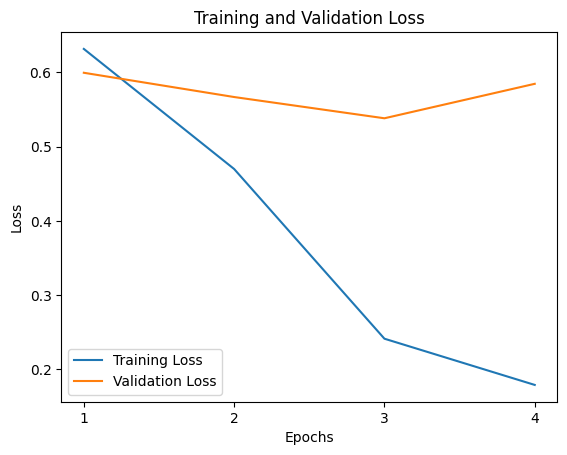

metrics_0: {'accuracy_score': 0.7840909090909091, 'precision_score': 0.8, 'recall_score': 0.782608695652174, 'f1_score': 0.7912087912087912}
 metrics_1: {'accuracy_score': 0.7840909090909091, 'precision_score': 0.7674418604651163, 'recall_score': 0.7857142857142857, 'f1_score': 0.7764705882352941}
              precision    recall  f1-score   support

    Truthful       0.77      0.79      0.78        84
        Fake       0.80      0.78      0.79        92

    accuracy                           0.78       176
   macro avg       0.78      0.78      0.78       176
weighted avg       0.78      0.78      0.78       176



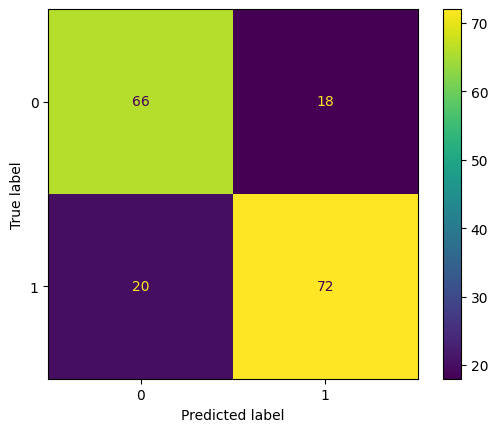

###############################-Final Test-#######################################
metrics_0: {'accuracy_score': 0.789838337182448, 'precision_score': 0.8018433179723502, 'recall_score': 0.7837837837837838, 'f1_score': 0.7927107061503417}
 metrics_1: {'accuracy_score': 0.789838337182448, 'precision_score': 0.7777777777777778, 'recall_score': 0.7962085308056872, 'f1_score': 0.7868852459016393}
              precision    recall  f1-score   support

    Truthful       0.78      0.80      0.79       211
        Fake       0.80      0.78      0.79       222

    accuracy                           0.79       433
   macro avg       0.79      0.79      0.79       433
weighted avg       0.79      0.79      0.79       433



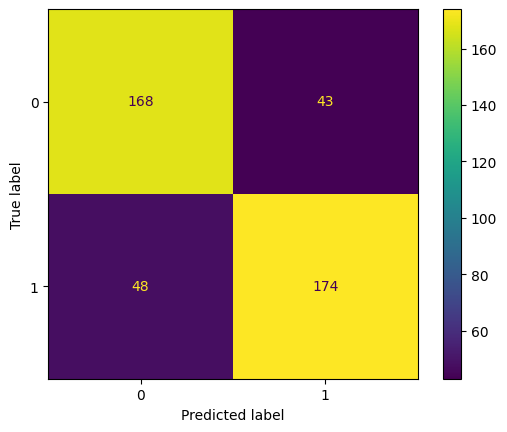

In [16]:
pipeline(data_paths, model, optimizer, train_model, test_model)

# Exit

In [17]:
exit()